# Assignment 4: Advanced Hyperparameter Tuning

-----------

## Exercise 1: Extend Random Search

In [16]:
import shutil
import os
import keras
from datetime import datetime
import numpy as np

from utils import start_tensorboard

start_tensorboard()

📊 TensorBoard Setup Instructions

1. Open a terminal in Azure ML Studio

2. Run this command:

   tensorboard --logdir c:\Data\!Hagenberg\!Hagenberg\Semester3\NDL\Repo\NDL3\assignments\assignment_4\logs --host 0.0.0.0 --port 6006

3. Open this URL in your browser:

   https://Lorenz-Laptop-6006.swedencentral.instances.azureml.ms



'https://Lorenz-Laptop-6006.swedencentral.instances.azureml.ms'

# Fully Connected Neural Networks: Part 2 - First Image Classification
After getting to know a basic assortment of layer types and activation functions, we will switch our task to image classification, showing some of the limitations of pure fully connected (dense) neural networks. We will evaluate a moderately deep network with a quite standard layout and do some basic random paramter and achritecture search.


In [17]:
# %pip install scikit-image

In [18]:
# load data
import keras
import numpy as np
from skimage.transform import resize


sym_dim=8
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0 #this is how we normally scale with images
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0 #same for test


X_train = resize(X_train.reshape(-1, 28, 28), (len(X_train), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")
X_test = resize(X_test.reshape(-1, 28, 28), (len(X_test), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")


X_train: (60000, 64), y_train: (60000,)
X_test: (10000, 64), y_test: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


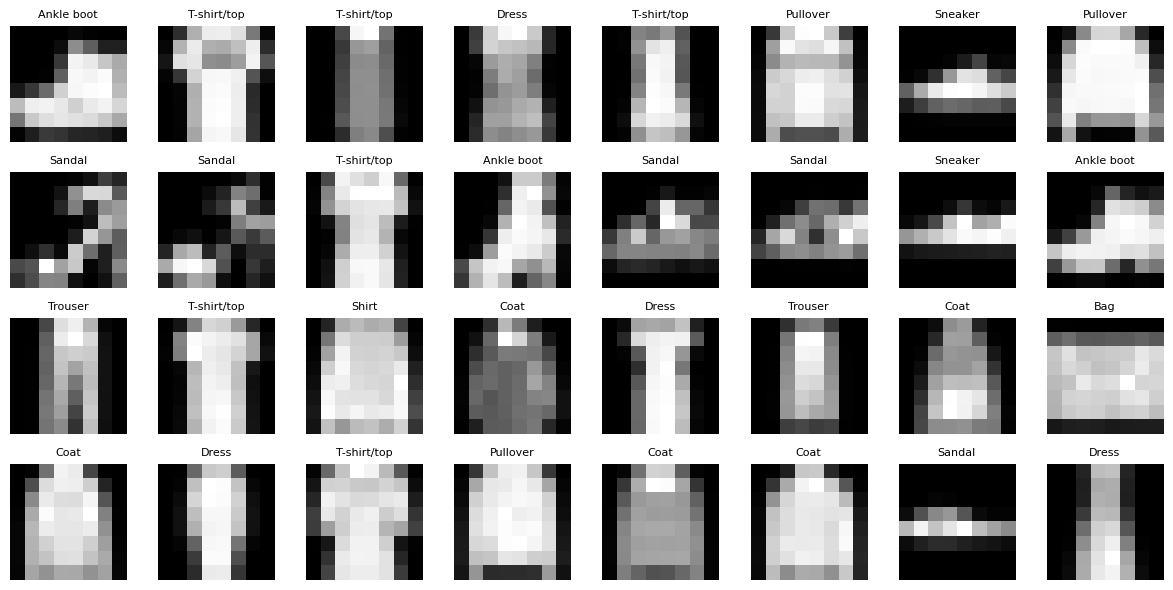

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(sym_dim, sym_dim), cmap='gray')
    ax.set_title(class_names[y_train[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
def create_fcnn(
    input_dim: int,
    num_classes: int,
    hidden_layers: list[int] = [512, 256, 128],
    dropout_rate: float = 0.3,
    activation: str = "relu",
    learning_rate: float = 0.001,
    batch_size: int = 32,
    name: str = "fcnn"
) -> keras.Model:
    
    inputs = keras.layers.Input(shape=(input_dim,))
    x = inputs
    
    for i, units in enumerate(hidden_layers):
        x = keras.layers.Dense(units)(x)
        x = keras.layers.Activation(activation=activation)(x)
        if dropout_rate > 0:
            x = keras.layers.Dropout(dropout_rate)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [21]:
basic_model = create_fcnn(
    input_dim=sym_dim*sym_dim,
    num_classes=10,
    hidden_layers=[512, 256, 128],
    dropout_rate=0.3,
    name="fashion_fcnn"
)
basic_model.summary()

Model: "fashion_fcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,794 (776.54 KB)

 Trainable params: 198,794 (776.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7428 - loss: 0.6935 - val_accuracy: 0.8217 - val_loss: 0.4890
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8114 - loss: 0.5187 - val_accuracy: 0.8276 - val_loss: 0.4669
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8231 - loss: 0.4802 - val_accuracy: 0.8427 - val_loss: 0.4296
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8308 - loss: 0.4566 - val_accuracy: 0.8381 - val_loss: 0.4301
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8372 - loss: 0.4425 - val_accuracy: 0.8428 - val_loss: 0.4121
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8419 - loss: 0.4270 - val_accuracy: 0.8562 - val_loss: 0.3846
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8463 - loss: 0.4178 - val_accuracy: 0.8499 - val_loss: 0.4067
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8495 - loss: 0.4099 - 

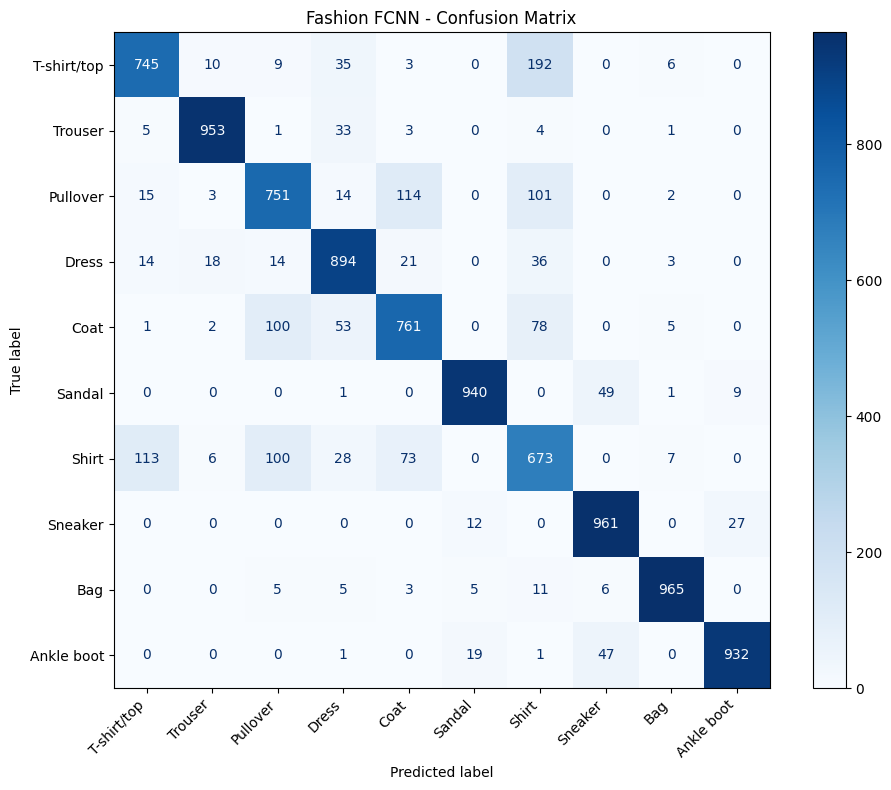

(0.3836200535297394, 0.8575000166893005)

In [22]:
from utils import train_model, eval_classification

basic_fcnn_history = train_model(basic_model, X_train, y_train, "basic_functional_api", epochs=10)      
eval_classification(basic_model, X_test, y_test, class_names, "Fashion FCNN")

## PART b - Fixing the Data leak:

It was used the same data for trainig and afterwards for validation: so lthe train and val set overlaped -> DATA LEAK

The model "sees" the val data during training - this influences the val accuracy because it gets inflated and meaningless


**FIX:**
Do a split which splitts 80% training data and 20% val data - so the date i val on the set afterwards is "new" for the model

In [23]:
import random
import pandas as pd
from sklearn.model_selection import train_test_split

def create_hyperparams(
    n: int,
    num_layers_range: tuple[int, int] = (1, 4),
    units_choices: list[int] = [128, 256, 512],
    dropout_range: tuple[float, float] = (0.1, 0.5),
    learning_rate_range=(0.0001, 0.01),               # Add learning rate search
    batch_size_choices=[16, 32, 64, 128],             # Add batch size variation
    activation_choices=["relu", "tanh", "elu"],       # Add activation function choice
) -> pd.DataFrame:
    
    params_list = []
    for _ in range(n):
        ##added in the param list here:
        params_list.append({
            "hidden_layers": [random.choice(units_choices) for _ in range(random.randint(*num_layers_range))],
            "dropout_rate": round(random.uniform(*dropout_range), 3),
            "learning_rate": round(random.uniform(*learning_rate_range), 5),
            "activation": random.choice(activation_choices),
            "batch_size": random.choice(batch_size_choices),
        })
    return pd.DataFrame(params_list)


def run_search(
    hp_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 10,
) -> tuple[keras.Model, dict, pd.DataFrame]:
    
    from utils import train_model
    ###### PART B - FIX DATA LEAK HERE ######
    ##create train val split here:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    results = hp_df.copy()
    results["val_acc"] = -1.0
    models = {}
    
    for i, row in hp_df.iterrows():
        ##added parameters here:
        params = {
            "hidden_layers": row["hidden_layers"],
            "dropout_rate": row["dropout_rate"],
            "learning_rate": row["learning_rate"],
            "activation": row["activation"],
            # "batch_size": row["batch_size"],
        }
        
        model = create_fcnn(input_dim=X_train.shape[1], num_classes=10, name=f"trial_{i}", **params)
        
        layers_str = "_".join(map(str, params["hidden_layers"]))
        model_name = f"rs_L{layers_str}_D{int(params['dropout_rate'])}"
        ##add batch size here:
        model, _ = train_model(model, X_train, y_train, model_name=model_name, epochs=epochs, early_stopping=True, verbose=0, batch_size=row["batch_size"])
        
        ## PART B - FIX DATA LEAK HERE ##
        _, val_acc = model.evaluate(X_val, y_val, verbose=0)
        ## WRONG / Original:
        # _, val_acc = model.evaluate(X_train[:10000], y_train[:10000], verbose=0)
        
        results.loc[i, "val_acc"] = round(val_acc, 4)
        models[i] = model
        
        print(f"Trial {i+1}/{len(hp_df)}: acc={val_acc:.4f}")
    
    results = results.sort_values("val_acc", ascending=False).reset_index(drop=True)
    best_idx = results.iloc[0].name if "name" in dir(results.iloc[0]) else 0

    print(best_idx)
    
    print(f"\n✓ Best: val_acc={results.iloc[0]['val_acc']:.4f}")
    return models[hp_df.index[results.index[0]]], results.iloc[0].to_dict(), results

### Task: add 3 additional hyperparameters:

Why you chose this parameter  
What range/values you selected and why  
What impact you expect it to have

- **learning_rate_range** = (0.0001, 0.01)
  - Why: Main control of optimizer step size; drives convergence speed/stability.
  - Range: 0.0001, 0.01
  - Impact: 
    + Higher -> faster, risk overshoot 
    + lower -> stable, slower

- **activation_choices** = ["relu", "tanh", "elu"]
  - Why: Nonlinearity affects gradient flow and representational capacity.
  - Values: 
    + ReLU (fast baseline)
    + Tanh (bounded/symmetric, may saturate)
    + ELU (mitigates dying ReLU, zero-mean shift).
  - Impact: Changes training dynamics; ReLU often fastest, ELU more stable, Tanh can slow due to saturation.

- **batch_size_choices** = [16, 32, 64, 128]
  - Why: Trade-off between gradient noise (regularization) and throughput/memory.
  - Values: Small->more noise; large->smoother, faster; common powers of two.
  - Impact: Smaller batches may generalize better but train slower; larger batches train faster and may favor slightly higher learning rates.

In [24]:
#TASK 1

hp_df = create_hyperparams(
    n=100,          # to get 100 configs
    num_layers_range=(1, 4),
    units_choices=[64, 128, 256, 512],
    dropout_range=(0.0, 0.4),
    learning_rate_range=(0.0001, 0.01),               # Add learning rate search
    activation_choices=["relu", "tanh", "elu"],       # Add activation function choice
    batch_size_choices=[16, 32, 64, 128],              #Add batch size
)
hp_df

,hidden_layers,dropout_rate,learning_rate,activation,batch_size
0,"[256, 512, 64]",0.082,0.00021,elu,64
1,"[512, 256, 512, 64]",0.120,0.00557,elu,64
2,"[128, 256, 512]",0.000,0.00241,elu,16
3,"[256, 256, 512]",0.344,0.00089,tanh,32
4,"[256, 64, 256, 64]",0.290,0.00532,relu,128
...,...,...,...,...,...
95,[256],0.367,0.00660,elu,64
96,"[128, 128]",0.293,0.00777,relu,16
97,"[64, 128, 64]",0.145,0.00331,relu,64
98,"[128, 64]",0.091,0.00783,tanh,64


In [25]:
best_model, best_params, results_df = run_search(hp_df, X_train, y_train, epochs=20)
results_df


Restoring model weights from the end of the best epoch: 20.
Trial 1/100: acc=0.8514
Restoring model weights from the end of the best epoch: 18.
Trial 2/100: acc=0.8373
Restoring model weights from the end of the best epoch: 13.
Trial 3/100: acc=0.8569
Restoring model weights from the end of the best epoch: 20.
Trial 4/100: acc=0.8525
Restoring model weights from the end of the best epoch: 20.
Trial 5/100: acc=0.8418
Restoring model weights from the end of the best epoch: 15.
Trial 6/100: acc=0.8295
Restoring model weights from the end of the best epoch: 16.
Trial 7/100: acc=0.8439
Restoring model weights from the end of the best epoch: 20.
Trial 8/100: acc=0.8698
Restoring model weights from the end of the best epoch: 20.
Trial 9/100: acc=0.8514
Restoring model weights from the end of the best epoch: 20.
Trial 10/100: acc=0.8072
Restoring model weights from the end of the best epoch: 15.
Trial 11/100: acc=0.8198
Restoring model weights from the end of the best epoch: 19.
Trial 12/100: 

,hidden_layers,dropout_rate,learning_rate,activation,batch_size,val_acc
0,"[256, 256]",0.207,0.00155,relu,128,0.8733
1,"[512, 256, 512]",0.040,0.00304,relu,128,0.8708
2,"[256, 64]",0.175,0.00314,relu,128,0.8698
3,"[256, 128, 256]",0.019,0.00126,tanh,32,0.8690
4,"[64, 256, 128, 128]",0.034,0.00062,elu,128,0.8648
...,...,...,...,...,...,...
95,"[256, 128, 512, 128]",0.096,0.00805,tanh,64,0.7778
96,"[64, 128, 64, 256]",0.160,0.00511,tanh,16,0.7732
97,"[128, 512, 512]",0.350,0.00688,tanh,32,0.7663
98,"[64, 256, 256]",0.376,0.00592,relu,16,0.7425


In [26]:
print("Best Hyperparameters:\n")
print(best_params)
print("Best Model Evaluation:\n")
print(best_model.evaluate(X_test, y_test, verbose=0))

print("results dataframe:\n")
print(results_df)


Best Hyperparameters:

{'hidden_layers': [256, 256], 'dropout_rate': 0.207, 'learning_rate': 0.00155, 'activation': 'relu', 'batch_size': 128, 'val_acc': 0.8733}
Best Model Evaluation:

[0.4210450053215027, 0.8474000096321106]
results dataframe:

           hidden_layers  dropout_rate  learning_rate activation  batch_size  \
0             [256, 256]         0.207        0.00155       relu         128   
1        [512, 256, 512]         0.040        0.00304       relu         128   
2              [256, 64]         0.175        0.00314       relu         128   
3        [256, 128, 256]         0.019        0.00126       tanh          32   
4    [64, 256, 128, 128]         0.034        0.00062        elu         128   
..                   ...           ...            ...        ...         ...   
95  [256, 128, 512, 128]         0.096        0.00805       tanh          64   
96    [64, 128, 64, 256]         0.160        0.00511       tanh          16   
97       [128, 512, 512]         

In [ ]:
results_df.to_csv("hyperparameter_search_results.csv", index=False)

### BEST parameters:

- hidden layers: [256,256]  -> shallow 2-layer network with 256 units per layer outperformed deeper configurations
- dropout_rate: 0.207
- learning_rate: 0.00155    -> for this configuration careful optimization is needed 
- activation: relu
- batch_size: 128   -> larger batches improve stability
- **val_acc:** 87.33%


Near-ties: Several configs within 0.002–0.003 val_acc of the best. Many of them also use batch=128 and ReLU with low-to-moderate dropout. This suggests the search space has multiple shallow optima; picking any of the top 3–5 is likely similar.